<a href="https://colab.research.google.com/github/KGzB/CAS-Applied-Data-Science/blob/master/Module-1/M1-D3-WWW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook 1, Module 1, Data and Data Management, CAS Applied Data Science, 2024-08-23, A. Mühlemann, University of Bern. (based on the template by S. Haug)


# 3. Data acquisition on the world wide web

**Learning outcomes:**

Participants will be able to collect data from www sources. Examples are provided and exercised. We have about 1.5h hours for this tutorial.

**Table of Contents**
- 3.1 Read json from the web
- 3.2 Retrieve and display pictures and files from the web
- 3.3 Scraping webpages (html scraping)
- 3.4 Cron jobs and Scheduled tasks
- Some notes and links concerning social media

**Further sources**
- Examples all over internet
- A book: https://www.packtpub.com/big-data-and-business-intelligence/mastering-social-media-mining-python


## 3.1 Analyse Aare with data from https://aareguru.existenz.ch/



Get the data from website, bring it into a format which can be imported into a dataframe, plot the time series and the histograms.

In [20]:
import requests
import pandas as pd
from datetime import datetime

# URL of the Aare Guru API only getting infos from bern
url = 'https://aareguru.existenz.ch/v2018/current?city=bern'

# Send GET request to the API
response = requests.get(url)
data = response.json()  # Parse the JSON response
df = pd.DataFrame(data['aarepast']) # Get the past flow and water temperature and save it in a data frame
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') # change datetime
df

,timestamp,flow,temperature
0,2025-08-16 12:20:00,133,22.63
1,2025-08-16 12:40:00,133,22.76
2,2025-08-16 13:00:00,132,22.88
3,2025-08-16 13:20:00,131,22.93
4,2025-08-16 13:40:00,131,22.98
...,...,...,...
213,2025-08-18 11:20:00,164,21.06
214,2025-08-18 11:30:00,162,21.07
215,2025-08-18 11:40:00,162,21.08
216,2025-08-18 11:50:00,161,21.09


Get a rough overview of the data set we obtained

In [21]:
df.describe()

,timestamp,flow,temperature
count,218,218.000000,217.000000
mean,2025-08-17 15:21:18.440367104,160.467890,21.427880
min,2025-08-16 12:20:00,130.000000,20.020000
25%,2025-08-17 03:55:00,151.000000,20.580000
50%,2025-08-17 17:35:00,167.000000,21.310000
75%,2025-08-18 02:57:30,168.000000,22.200000
max,2025-08-18 12:00:00,169.000000,23.070000
std,NaN,11.905595,0.903754


Plot water temperature.

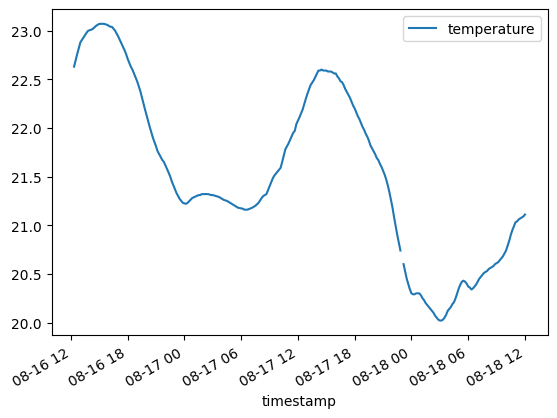

In [22]:
import matplotlib.pyplot as plt
df.plot(x='timestamp', y='temperature', kind='line')
plt.show()

Let us now compare the aare temperature in Bern with the air temperature and percipitation. You can find the documentation of this API here: https://open-meteo.com/en/docs

In [23]:
# URL of weather api
url = 'https://api.open-meteo.com/v1/forecast?latitude=52.52&longitude=13.41&past_days=10&hourly=temperature_2m,precipitation'

# Send GET request to the API
response = requests.get(url)
data = response.json()  # Parse the JSON response
df2 = pd.DataFrame(data['hourly']) # Get the past flow and water temperature and save it in a data frame
df2['time'] = pd.to_datetime(df2['time']) # change datetime
df2


,time,temperature_2m,precipitation
0,2025-08-08 00:00:00,19.1,0.0
1,2025-08-08 01:00:00,18.8,0.0
2,2025-08-08 02:00:00,18.4,0.0
3,2025-08-08 03:00:00,18.6,0.0
4,2025-08-08 04:00:00,18.2,0.0
...,...,...,...
403,2025-08-24 19:00:00,15.5,0.0
404,2025-08-24 20:00:00,14.2,0.0
405,2025-08-24 21:00:00,13.1,0.0
406,2025-08-24 22:00:00,12.3,0.0


Let's also plot the temperature.

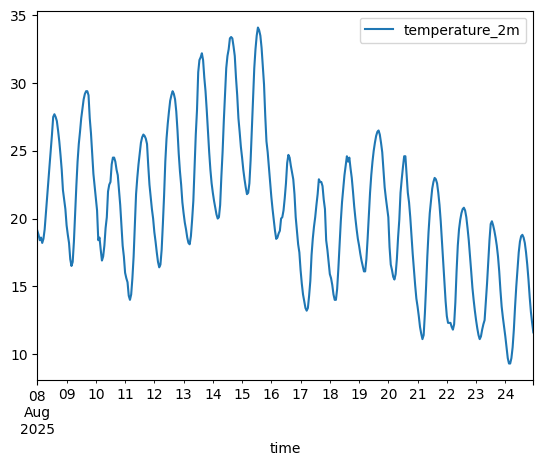

In [24]:
df2.plot(x='time', y='temperature_2m', kind='line')
plt.show()

We can see that the two timeseries have a different scope. Let us thus only take the timepoints that occur in both time series.

In [25]:
df2.rename(columns={'time': 'timestamp'}, inplace=True)
df_new =pd.merge(df, df2, on='timestamp', how='left') # we use a left join to have the fine timegrid from the aare data
df_new

,timestamp,flow,temperature,temperature_2m,precipitation
0,2025-08-16 12:20:00,133,22.63,NaN,NaN
1,2025-08-16 12:40:00,133,22.76,NaN,NaN
2,2025-08-16 13:00:00,132,22.88,24.1,0.0
3,2025-08-16 13:20:00,131,22.93,NaN,NaN
4,2025-08-16 13:40:00,131,22.98,NaN,NaN
...,...,...,...,...,...
213,2025-08-18 11:20:00,164,21.06,NaN,NaN
214,2025-08-18 11:30:00,162,21.07,NaN,NaN
215,2025-08-18 11:40:00,162,21.08,NaN,NaN
216,2025-08-18 11:50:00,161,21.09,NaN,NaN


Now let us plot the air and water temperature to see whether there is a correlation.

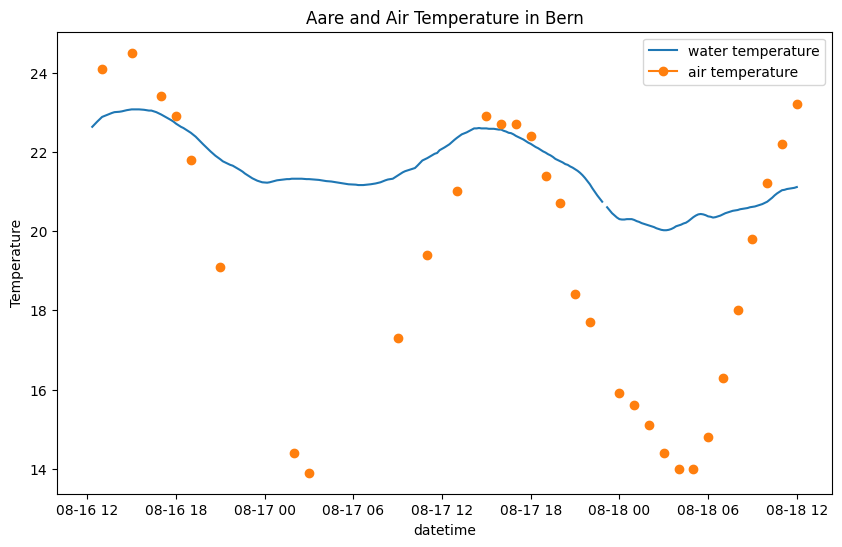

In [26]:
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size
plt.plot(df_new['timestamp'], df_new['temperature'], label="water temperature")
plt.plot(df_new['timestamp'], df_new['temperature_2m'], label="air temperature", marker='o' )
# Customize the plot
plt.xlabel('datetime')
plt.ylabel('Temperature')
plt.title('Aare and Air Temperature in Bern')
plt.legend()
plt.show()

**Possible further exercise or project for Module 1 and 2**

Find some colleague who can get the historical data (knows how to use the API) out of https://aareguru.existenz.ch/. Bring all data into one data frame. Look for correlations, averages (per month, per year ...). Combine the data with weather data, e.g. the wind on the Thun lake. For the Model 2 project, try to make a linear regression model predicting the Aare temperature.

## 3.2 Get pictures (or files) from webpages

Get 3 pictures from a webserver with the Image module and show it directly.

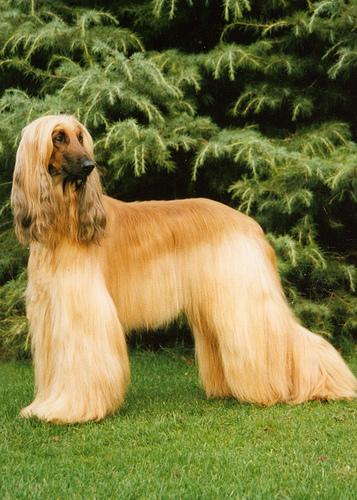

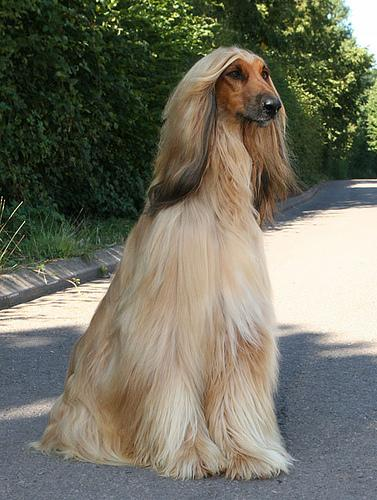

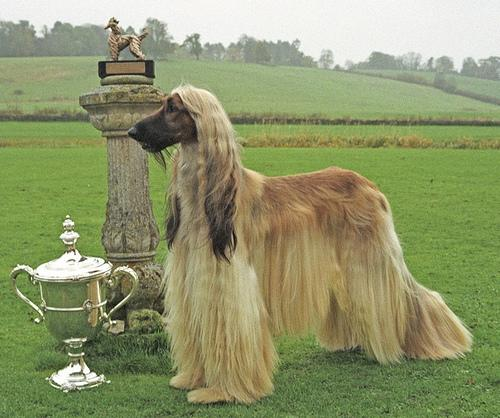

In [27]:
import requests
import pandas as pd
from datetime import datetime
from IPython.display import Image, display

# URL of weather api
url = ' https://dog.ceo/api/breed/hound/images'

# Send GET request to the API
response = requests.get(url)
data = response.json()
dog_images = pd.DataFrame(data)
for i in range(1,4):
    url = dog_images.iat[i,0]
    img = Image(url)
    display(img)

### Exercise
There is an API giving some cat pictures (https://api.thecatapi.com/v1/images/search?limit=10). Can you adapt the above code to obtain pictures of cats?

## 3.3 Scrape Webpages (html scraping)

There are several billion online websites. With python you can easily read and parse this data if you have the links. Since pages are linked, one can in principle unnest probably all internet for webpages.

In Python there is a library https://www.crummy.com/software/BeautifulSoup/bs4/doc/ for pulling data out of html and xml pages. We don't practise that library here, however, if you at some point deal with a lot of html, you may want to use it.

Here we get the email adresses from a contact page of a website.


In [28]:
from urllib.request import urlopen
import numpy as np
import pandas as pd

startlink = "https://www.zeilenwerk.ch/agentur"
f = urlopen(startlink)
myfile = f.read()
str(myfile)
lines = str(myfile).split(' ')
addresses = []
for line in lines:
    if 'mailto' in line:
        tmp = np.array(line.split('"'))
        if len(tmp)== 3:
          tmp2 = np.array(tmp[1].split(':'))
          addresses.append(tmp2[1])
df_addrs = pd.DataFrame(addresses,columns=['Adresses'])
df_addrs

,Adresses
0,dario@zeilenwerk.ch
1,andreas@zeilenwerk.ch
2,raphael@zeilenwerk.ch
3,urs@zeilenwerk.ch
4,jaro@zeilenwerk.ch
5,alessandra@zeilenwerk.ch
6,cyril@zeilenwerk.ch
7,martin.buchs@zeilenwerk.ch
8,nicole@zeilenwerk.ch
9,jessica@zeilenwerk.ch


The above code is not optimal as you have probably seen. Lets use regular expressions instead (from StackOverflow). Regular expressions are a bit geeky, but very powerful and great fun. If you don't wan't to learn them, you mostly find the expression you want by googling.

In [29]:
import re # the regular expression module
startlink = "https://www.zeilenwerk.ch/agentur"
f = urlopen(startlink)
html = f.read()
# Extract email addresses
reobj = re.compile(r"\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,6}\b", re.IGNORECASE)
print(re.findall(reobj, html.decode('utf-8')))

['johannes@zeilenwerk.ch', 'johannes@zeilenwerk.ch', 'manuela@zeilenwerk.ch', 'manuela@zeilenwerk.ch', 'andrea@zeilenwerk.ch', 'andrea@zeilenwerk.ch', 'dario@zeilenwerk.ch', 'dario@zeilenwerk.ch', 'matthias@zeilenwerk.ch', 'matthias@zeilenwerk.ch', 'cyril@zeilenwerk.ch', 'cyril@zeilenwerk.ch', 'mario@zeilenwerk.ch', 'mario@zeilenwerk.ch', 'tobias@zeilenwerk.ch', 'tobias@zeilenwerk.ch', 'urs@zeilenwerk.ch', 'urs@zeilenwerk.ch', 'tobias.feller@zeilenwerk.ch', 'tobias.feller@zeilenwerk.ch', 'martin.buchs@zeilenwerk.ch', 'martin.buchs@zeilenwerk.ch', 'andreas@zeilenwerk.ch', 'andreas@zeilenwerk.ch', 'merlin@zeilenwerk.ch', 'merlin@zeilenwerk.ch', 'raphael@zeilenwerk.ch', 'raphael@zeilenwerk.ch', 'lukas.lazarcik@zeilenwerk.ch', 'lukas.lazarcik@zeilenwerk.ch', 'nicole@zeilenwerk.ch', 'nicole@zeilenwerk.ch', 'jessica@zeilenwerk.ch', 'jessica@zeilenwerk.ch', 'alessandra@zeilenwerk.ch', 'alessandra@zeilenwerk.ch', 'janosch@zeilenwerk.ch', 'janosch@zeilenwerk.ch', 'jaro@zeilenwerk.ch', 'jaro@zei

### Exercise

Hier a nice little challenge for you. Use the code above (together with a for loop or two) to scrape all webpages of your employer company for public available email addresses and put them into a dataframe :)

In [30]:
# Write, copy and paste your code here


### Tables from webpages

If you or someone else pubslishes data in html tables, it can be collected with pandas quite easily, actually directly without using the urllib module.

In [31]:
import pandas as pd
link = "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population"
tables = pd.read_html(link)
df = tables[0]
df.head()

,Location,Population,% of world,Date,Source (official or from the United Nations),Notes
0,World,8232000000,100%,13 Jun 2025,UN projection[1][3],NaN
1,India,1417492000,17.3%,1 Jul 2025,Official projection[4],[b]
2,China,1408280000,17.2%,31 Dec 2024,Official estimate[5],[c]
3,United States,340110988,4.2%,1 Jul 2024,Official estimate[6],[d]
4,Indonesia,284438782,3.5%,30 Jun 2025,National annual projection[7],NaN


Which countries have the largest population?

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 6 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Location                                      242 non-null    object
 1   Population                                    242 non-null    int64 
 2   % of world                                    242 non-null    object
 3   Date                                          242 non-null    object
 4   Source (official or from the United Nations)  242 non-null    object
 5   Notes                                         33 non-null     object
dtypes: int64(1), object(5)
memory usage: 11.5+ KB


In [33]:
s_df = df.iloc[1:,1:3]
s_df.sort_values('Population', ascending=False)

,Population,% of world
1,1417492000,17.3%
2,1408280000,17.2%
3,340110988,4.2%
4,284438782,3.5%
5,241499431,2.9%
...,...,...
237,1681,0%
238,1647,0%
239,882,0%
240,593,0%


### Exercise
Find another interesting table to scrape from Wikipedia and look at it more closely.

## Some notes and links concerning social Media

### 1. Google search

There is are APIs for doing google searches from Python. Hier is one explained.

https://stackoverflow.com/questions/37083058/programmatically-searching-google-in-python-using-custom-search


### 2. Twitter

Twitter generates about 500M tweets per day. Thus, data mining on twitter can be interesting.

Note: there are rate limits in the use of the Twitter API, as well as limitations in case you want to provide a downloadable data-set, see:

https://dev.twitter.com/overview/terms/agreement-and-policy

https://dev.twitter.com/rest/public/rate-limiting

Tweepy is one python module with clients for thwe Twitter API.

- https://www.tweepy.org/


### 3. Instagram

Largest photo sharing social media platform with 500 million monthly active users, and 95 million pictures and videos uploaded on Instagram daily in 2018 (?).

https://stackoverflow.com/questions/61010431/how-to-start-with-the-instagramapi-in-python